## Setup

All libraries that are used throughout the code.

In [9]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install keras
%pip install tensorflow
%pip install plotly_express
%pip install nltk
%pip install gensim
%pip install gdown
%pip install fasttext
%pip install imbalanced-learn
%pip install nltk pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227136 sha256=edb4080ae8d57454d0e009abbc42b17b24582ab9d7ace107a4e8523180689245
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from gensim.models import KeyedVectors
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords as sw
from nltk.tokenize import WhitespaceTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, fbeta_score, classification_report
from keras.utils import to_categorical
import gdown
from gensim.models import FastText

from sklearn.model_selection import GridSearchCV, learning_curve
import string
import re
import fasttext
from sklearn import svm
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.utils import resample


## Word2Vec

Word2Vec is a machine learning model that transforms words into numerical vectors, capturing their contexts and semantic meanings. Trained on large text datasets, it utilizes techniques such as Continuous Bag of Words (CBOW) and Skip-gram to predict words based on their contexts or vice versa. Words that occur in similar contexts end up with vectors that are close together in a high-dimensional space. These vectors, known as embeddings, enable the capture of semantic relationships between words and are used in various natural language processing (NLP) tasks such as text classification and machine translation. For more information about the model visit documentation [session 9.3 Word2Vec](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#93-word2vec).

In this section, we will be demonstrating Word2Vec in a way that does not use pre-trained models, meaning that the authorship of the results is entirely by the group.

Data reading:

In [ ]:
path = 'data/classification-labeled.csv'

try:
    data = pd.read_csv(path, encoding='ISO-8859-1', delimiter=';')
except UnicodeDecodeError:
    try:
        data = pd.read_csv(path, encoding='windows-1252')
    except UnicodeDecodeError:
        data = pd.read_csv(path, encoding='utf-16')


sentences = data['comment'].apply(simple_preprocess).tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'data/classification-labeled.csv'

Word2Vec training:

Here we can define if we use either CBOW or skip-gram, if it's desirable to use skip-grap, we add the parameter (sg=1), and if CBOW is considered as the best option, the parameter isn't necessary.

In [ ]:
word2vec_model = Word2Vec(sentences=sentences, vector_size=600, window=5, min_count=1, workers=4)

Tokenization:

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

max_sequence_length = max(len(seq) for seq in sequences)
word_index = tokenizer.word_index

data_padded = pad_sequences(sequences, maxlen=max_sequence_length)


Creation of the vectors for each sentence:

In [ ]:
def get_sum_vector(sentence, model, vector_size):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.sum(vectors, axis=0)
    else:
        return np.zeros(vector_size)

vector_size = 600
X = np.array([get_sum_vector(sentence, word2vec_model, vector_size) for sentence in sentences])
y = data['sentiment'].values


Data normalization:

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Model Fit:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


classifier = GaussianNB(var_smoothing=1e-09)
classifier.fit(X_train, y_train)


Model testeing:

In [ ]:
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

Dataframe and csv creation:

In [ ]:
df = pd.DataFrame(X_scaled)
df['sentiment'] = y

df.to_csv('word2vec_features.csv', index=False)
path2 = '/content/word2vec_features.csv'
df_w2v = pd.read_csv(path2)
df_w2v.head(5)

### Naive Bayes Word2Vec

#### Why Naive Bayes?

&emsp;&emsp;In this notebook, we implement different variants of the Naive Bayes model for the task of sentiment classification of Uber customer reviews. This approach uses pre-trained word embeddings (Word2Vec) to convert texts into vector representations, which are then used to train the models.

&emsp;&emsp;Naive Bayes is often chosen as a baseline model for text classification tasks due to several reasons:
1. Simplicity and Efficiency: Naive Bayes is one of the simplest and fastest machine learning algorithms. Its implementation is straightforward, and it requires fewer computational resources, making it suitable for large volumes of data.
2. Few Parameters to Tune: Naive Bayes has few parameters to tune, which simplifies its use and reduces the need for extensive hyperparameter optimization. This is particularly useful in an initial scenario where the focus is on obtaining results quickly for a preliminary evaluation.

#### Limitations of Naive Bayes:

&emsp;&emsp;Although Naive Bayes is an excellent starting point, it has its limitations:
1. Independence Assumption: Naive Bayes assumes that all features are independent of each other. In the context of text, this means it considers each word in a document independently, ignoring the dependency between words that can be crucial for understanding the context.
2. Performance on Imbalanced Data: Naive Bayes can be sensitive to imbalanced data. If one class is significantly larger than others, the model may perform biasedly in favor of the majority class.
3. Doesn't Capture Complex Relationships: Due to its simplicity, Naive Bayes cannot capture complex relationships between features. More advanced models, like neural networks, can learn these relationships and generally outperform Naive Bayes on complex tasks.
4. Scalability with High Dimensionality: Although it is efficient with many features, Naive Bayes can face difficulties when the data dimensionality is extremely high, especially if the data is not well-prepared or if there is no dimensionality reduction.

#### Implementation
&emsp;&emsp;In this notebook, we explore three variants of Naive Bayes:

1. Gaussian Naive Bayes: Suitable for continuous data. We normalized the data before applying this model.
2. Multinomial Naive Bayes: Suitable for discrete data, such as word counts. We binarized the data before applying this model.
3. Bernoulli Naive Bayes: Suitable for binary data. We binarized the data before applying this model.

#### Results

&emsp;&emsp;We evaluated each model using performance metrics such as F1 Score, Recall, Precision, and Accuracy, with a primary focus on F1 Score, Recall, and Precision. The emphasis on these metrics is due to the project's critical need to avoid missing true negative values. Additionally, we plotted confusion matrices to visualize the performance in terms of correct and incorrect classifications.
&emsp;&emsp;Naive Bayes provides a solid foundation for the sentiment classification task, but its limitations indicate the need to explore more complex models to improve performance. This notebook serves as a starting point to understand the challenges and guide future developments towards more sophisticated models.




Loading the Dataset and Preparing the Data

In [ ]:
# Loading the dataset
#path2 = '../src/word2vec_features.csv'
path2 = '/content/word2vec_features.csv'
df_w2v = pd.read_csv(path2)
X = df_w2v.drop('sentiment', axis=1)
y = df_w2v['sentiment']

# Splitting the Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Training and Evaluation of Gaussian Naive Bayes

In [ ]:
# Training the Gaussian Naive Bayes model with adjusted var_smoothing
classifier_gnb = GaussianNB(var_smoothing=1e-09)
classifier_gnb.fit(X_train_scaled, y_train)

# Prediction on the validation data
y_pred_gnb = classifier_gnb.predict(X_val_scaled)

# Calculation of metrics
f1_gnb = f1_score(y_val, y_pred_gnb, average='weighted')
recall_gnb = recall_score(y_val, y_pred_gnb, average='weighted')
precision_gnb = precision_score(y_val, y_pred_gnb, average='weighted')
accuracy_gnb = accuracy_score(y_val, y_pred_gnb)

# Displaying the metrics
print("Gaussian Naive Bayes:")
print(f"F1 Score: {f1_gnb:.4f}")
print(f"Recall: {recall_gnb:.4f}")
print(f"Precision: {precision_gnb:.4f}")
print(f"Accuracy: {accuracy_gnb:.4f}")

Training and Evaluation of Multinomial Naive Bayes

In [ ]:
# Binarizing the selected data
binarizer = Binarizer()
X_train_binarized = binarizer.fit_transform(X_train_scaled)
X_val_binarized = binarizer.transform(X_val_scaled)

# Training the Multinomial Naive Bayes model
classifier_mnb = MultinomialNB()
classifier_mnb.fit(X_train_binarized, y_train)

# Prediction on the validation data
y_pred_mnb = classifier_mnb.predict(X_val_binarized)

# Calculation of metrics
f1_mnb = f1_score(y_val, y_pred_mnb, average='weighted')
recall_mnb = recall_score(y_val, y_pred_mnb, average='weighted')
precision_mnb = precision_score(y_val, y_pred_mnb, average='weighted')
accuracy_mnb = accuracy_score(y_val, y_pred_mnb)

# Displaying the metrics
print("Multinomial Naive Bayes:")
print(f"F1 Score: {f1_mnb:.4f}")
print(f"Recall: {recall_mnb:.4f}")
print(f"Precision: {precision_mnb:.4f}")
print(f"Accuracy: {accuracy_mnb:.4f}")


Training and Evaluation of Bernoulli Naive Bayes

In [ ]:
# Training the Bernoulli Naive Bayes model
classifier_bnb = BernoulliNB()
classifier_bnb.fit(X_train_scaled, y_train)

# Prediction on the validation data
y_pred_bnb = classifier_bnb.predict(X_val_scaled)

# Calculation of metrics
f1_bnb = f1_score(y_val, y_pred_bnb, average='weighted')
recall_bnb = recall_score(y_val, y_pred_bnb, average='weighted')
precision_bnb = precision_score(y_val, y_pred_bnb, average='weighted')
accuracy_bnb = accuracy_score(y_val, y_pred_bnb)

# Displaying the metrics
print("Bernoulli Naive Bayes:")
print(f"F1 Score: {f1_bnb:.4f}")
print(f"Recall: {recall_bnb:.4f}")
print(f"Precision: {precision_bnb:.4f}")
print(f"Accuracy: {accuracy_bnb:.4f}")

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plotting confusion matrix for Gaussian Naive Bayes
plot_confusion_matrix(y_val, y_pred_gnb, title='Confusion Matrix - Gaussian Naive Bayes')

# Plotting confusion matrix for Multinomial Naive Bayes
plot_confusion_matrix(y_val, y_pred_mnb, title='Confusion Matrix - Multinomial Naive Bayes')

# Plotting confusion matrix for Bernoulli Naive Bayes
plot_confusion_matrix(y_val, y_pred_bnb, title='Confusion Matrix - Bernoulli Naive Bayes')


Metrics

Given the project's emphasis on correctly identifying negative sentiments, recall is the most critical metric. A higher recall indicates the model is effectively identifying most of the negative instances, reducing the chances of overlooking critical feedback.

**Gaussian Naive Bayes:**
- **Highest Precision (0.7372):** Indicates the model is good at predicting negative tweets correctly when it predicts them.
- **Highest Recall (0.5781):** Among the three models, this one captures the most actual negative tweets.
- **Highest F1 Score (0.6343):** Balances precision and recall, suggesting overall better performance.

**Multinomial Naive Bayes:**
- **Recall (0.5694):** Slightly lower than Gaussian Naive Bayes but still competitive.
- **Precision (0.7002):** Slightly lower than Gaussian Naive Bayes but better than Bernoulli Naive Bayes.
- **F1 Score (0.6197):** Lower than Gaussian Naive Bayes, indicating slightly less balanced performance.

**Bernoulli Naive Bayes:**
- **Recall (0.5590):** Lowest recall, indicating it misses more negative tweets compared to the other models.
- **Precision (0.7118):** Better than Multinomial Naive Bayes but not as good as Gaussian Naive Bayes.
- **F1 Score (0.6134):** Lowest overall, indicating less effective balance between precision and recall.

Given the need to prioritize the identification of true negatives (to minimize false negatives), **Gaussian Naive Bayes** is the preferred model. It achieves the highest recall, which is critical for capturing as many negative tweets as possible. Additionally, it has the highest F1 score, suggesting a good balance between precision and recall, making it the best model amoung the others for this task. For more information about the metrics visit [12.3 Word2Vec](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#123-Word2Vec).


### Embeding Layer

Embedding layer is a type of neural network layer commonly used in natural language processing to transform sparse, high-dimensional categorical data (like words) into dense, lower-dimensional continuous vectors. Each unique word in a vocabulary is mapped to a vector of real numbers which are learned as the model trains. These vectors capture semantic relationships between words, such that words with similar meanings are located close to each other in the vector space. This transformation facilitates more efficient processing and enables the model to perform better on tasks like classification, translation, and sentiment analysis by understanding the context and nuances of language better.








one-hot-ecoding of labels and applying SMOTE for class balancing

In [ ]:
labels = data['sentiment'].values + 1
labels_one_hot = to_categorical(labels, num_classes=3)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(data_padded, labels_one_hot)

X_train, X_val, y_train, y_val = train_test_split(X_train_smote, y_train_smote, test_size=0.4, random_state=42)

Creating the embedding matrix and model: The parameters of the model are adjusted for a multiclass classification model. Some parameters that are worth mentioning are:

- The big Dropout number, that in most cases isn't ideal, but as we are trying to avoid overfitting at all cost it is necessary.
- The softmax activation function is also ideal for multiclass classification problems.
- It is worth mentioning that as we are not working with a binary classification problem, it's necessary to use multiclass loss functions, such as the categorical_crossentropy function.
- The model is classified as trainable model, which lets the allows the model to learn from itself

In [ ]:
embedding_dim = 600
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=True))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Compiles the model:

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Generating the confusion matrix:

In [ ]:
y_pred = model.predict(X_val)


y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)


cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

As we can see, the model is very effective in identifying negative coments, succeding in >93% of cases (372 of 396). The cons of the embeding layer model are observed at identifying the positive comments which are beeing classified as neutral, which isn't a drawback if using the model commercialy, but affects the accuracy directly.

### Word2Vec with pre-trained dataframe

**Downloading pre-trained model**

This section mounts Google Drive to access files and downloads the pre-trained Word2Vec model and the dataset using the file IDs provided.

In [ ]:
# Permission to access Drive
from google.colab import drive
drive.mount('/content/drive')

 **Importing pre-trained model**

The pre-trained Word2Vec model is loaded from the downloaded binary file.

In [ ]:
file_id = "1nJ-Xl3rJ5lB_BH0yJ1YIRC4_ExNCU5L1"
url = f"https://drive.google.com/uc?id={file_id}"
output = "GoogleNews-vectors-negative300.bin"
gdown.download(url, output, quiet=False)

In [ ]:
pre_processed_model = 'GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(pre_processed_model, binary=True)

**Importing Uber dataset**

The dataset is loaded from the downloaded CSV file using pandas.



In [ ]:
file_id = "1D7MY7QKnOXMPWx6hqd0ASKrJRPjE3u_"
url = f"https://drive.google.com/file/d/{file_id}-/view?usp=drive_link"
output = "classification-labeled.csv"
gdown.download(url, output, quiet=False)

In [ ]:
#dataset = pd.read_csv("classification-labeled.csv", sep = ";")
dataset = pd.read_csv("/content/drive/MyDrive/dbs/classification-labeled.csv", encoding='ISO-8859-1', delimiter=';')

**Testing a random vector**

In [ ]:
v_hate = word_vectors["hate"]

v_hate

**Pre-processing Uber dataset**

Preprocesses comments in a dataset by removing stopwords, URLs, punctuation, and numbers.

  This function takes a dataset and a column as input. It first tokenizes the comments in the specified column using a WhitespaceTokenizer. Then, it removes stopwords (either in English or Portuguese), URLs, punctuation, and numbers from each comment. The cleaned comments are returned as a list.

  Parameters:
  dataset (pandas.DataFrame): The dataset containing the comments.
  column (str): The name of the column containing the comments.

  Returns:
  list: A list of processed comments.

In [ ]:
# Função de pré-processamento
def preprocess_comments(dataset, column):
    nltk.download('stopwords')
    stopwords = set(sw.words('english'))
    token_space = WhitespaceTokenizer()

    phase_processing = list()
    for comment in dataset[column]:
        word_text = token_space.tokenize(comment)
        new_comment = [w.lower() for w in word_text if not w.lower() in stopwords] # lowercase
        new_comment = [re.sub(r'http\S+|www.\S+', '', word) for word in new_comment] # remove HTML marks
        new_comment = [re.sub(r'[^\w\s]', '', word) for word in new_comment]  # remove punctuation
        new_comment = [re.sub(r'\d+', '', word) for word in new_comment]  # remove numbers
        phase_processing.append(' '.join(new_comment))

    return phase_processing

In [ ]:
# Calling a function preprocess_comments to preprocess a dataset of comments
preprocessing = preprocess_comments(dataset, 'comment')

In [ ]:
# Assigning the result of the preprocessing operation to a new column named 'preprocessing_data'
dataset['preprocessing_data'] = preprocessing

In [ ]:
dataset

In [ ]:
# See the content of the newly created column
dataset['preprocessing_data']

**Generating a vector representation**

Using the *get_sum_vector* function to generate vector representations for each sentence in the dataset's 'preprocessing_data' column and then creating a NumPy array X containing these vectors. Additionally, creating a NumPy array y containing the corresponding sentiment labels from the 'sentiment' column.

In [ ]:
def get_sum_vector(sentence, model, vector_size):
    vectors = [model[word] for word in sentence.split() if word in model]
    return np.sum(vectors, axis=0) if vectors else np.zeros(vector_size)

In [ ]:
vector_size = 300

X = np.array([get_sum_vector(comment, word_vectors, vector_size) for comment in dataset['preprocessing_data']])
y = dataset['sentiment'].values

**Verifying class balancing**

Address class imbalance to prevent the model from favoring the majority class. There have been used Random OverSampler to balance the distribution correctly.

In [ ]:
sns.countplot(x=y)
plt.title('Class distribution before balancing')
plt.show()

In [ ]:
# Using Random OverSampler to balance class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
# Verifying new balance
sns.countplot(x=y_resampled)
plt.title('Class distribution after balancing')
plt.show()

**Gaussian Naive Bayes Classifier**

Training Naive Bayes classifier to identify the Word2Vec model performance. For that, the balanced data was splitted into train and test. The Gaussian Naive Bayes was choosed for the classification, as it has the best performance for this kind of data. In the end, it was calculated the scores.

In [ ]:
# Dividing data sample between train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Training the model
clf = GaussianNB()
clf.fit(X_train, y_train)

In [ ]:
# Prevision on test sample
y_pred = clf.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
# Plot confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Confusion matrix')
plt.show()

**Calculating precision metrics**

In [ ]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [ ]:
print(classification_report(y_test, y_pred))

For more information about the metrics visit [12.3 Word2Vec](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#123-Word2Vec).

## FastText


FastText is a word representation model and machine learning technique developed by Facebook. It is an extension of the Word2Vec model, but instead of representing words as single vectors, FastText represents each word as a sum of n-gram vectors of characters. This allows FastText to handle rare words better and with less data, as even unknown words can be represented as n-gram combinations of known characters. For more information about the model visit documentation  [session 9.5 FastText](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#95-fasttext).


**Text Preprocessing Function:**
This function preprocesses the text data. It involves several steps:

Converting text to lowercase.
Removing punctuation.
Removing numbers.
Tokenizing text into words.
Removing stop words.
The function takes a text string as input and returns the preprocessed text.

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Text Preprocessing Function
def preprocess_text(text):
    """
    Preprocesses text:
        - Conversion to lowercase
        - Removal of punctuation
        - Removal of numbers
        - Tokenization
        - Removal of stop words

    Args:
        text (str): Text to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

This function converts text to a vector representation using the FastText model.

In [ ]:
def text_to_vector(text):
    """
    Converts text to vector using FastText.

    Args:
        text (str): Text to be converted to vector.

    Returns:
        numpy.ndarray: Vector representing the text.
    """
    # Text to vector conversion using FastText
    return model.get_sentence_vector(text)


**Load the Dataset and Preprocess Texts:** In this part, the dataset is loaded from a CSV file into a Pandas DataFrame. Text and label columns are extracted from the dataset. Texts are preprocessed using the preprocess_text() function defined earlier. Labels are converted to the FastText format with a prefix "label".

**Create Temporary Training File in FastText Format:** A temporary training file in FastText format is created. It iterates over preprocessed texts and corresponding labels, and writes them to the file in the format required by FastText. Each line in the file contains a label followed by the preprocessed text.

In [ ]:
# Load the dataset
dataset = pd.read_csv("data/classification-labeled.csv", sep=";")

texts = dataset['comment'].tolist()
labels = dataset['sentiment'].tolist()

texts = [preprocess_text(text) for text in texts]

labels = [f'__label__{label}' for label in labels]

train_data_path = 'train_data.txt'
with open(train_data_path, 'w', encoding='utf-8') as f:
    for text, label in zip(texts, labels):
        f.write(f'{label} {text}\n')


**Split Data into Train and Test Sets:**
The dataset is split into training and testing sets using the train_test_split function from scikit-learn. 85% of the data is used for training and 15% for testing. This step is crucial for evaluating the performance of the trained model on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.15, random_state=42)


**Train the FastText Model:**
This section initializes and trains the FastText model. Parameters like vector size, window size, minimum count, etc., are set during model initialization. The model vocabulary is built using the training data. Then, the model is trained on the training data using the train() method, passing the file path to the training data and other required parameters.

In [ ]:
model = FastText(vector_size=100, window=5, min_count=5, workers=4, sg=1, epochs=10)
model.build_vocab(corpus_file=train_data_path)
total_words = sum(1 for line in open(train_data_path, 'r'))
model.train(corpus_file=train_data_path, total_examples=len(texts), total_words=total_words, epochs=model.epochs)

**Generate Embeddings for Test Sentences:**
After training the FastText model, embeddings are generated for the test sentences. Each test sentence is tokenized into words, and the word vectors are averaged to obtain a sentence vector. These sentence vectors are used as input features for the classification model.

In [ ]:
X_test_vectors = [model.wv[sentence.split()].mean(axis=0) for sentence in X_test]

**Initialize and Train the Naive Bayes Classifier:**
A Gaussian Naive Bayes classifier is initialized. The sentence vectors obtained from the FastText model for the training set are used to fit the classifier.

In [ ]:
classifier = GaussianNB()
X_train_vectors = [model.wv[sentence.split()].mean(axis=0) for sentence in X_train]
classifier.fit(X_train_vectors, y_train)


**Make Predictions on the Test Set and Evaluate the Model:**
Predictions are made on the test set using the trained classifier. Various evaluation metrics such as accuracy, precision, recall, and F1-score are calculated using scikit-learn's functions. These metrics provide insights into the performance of the model on the test data.

In [ ]:
y_pred = classifier.predict(X_test_vectors)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')

# Print evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

**Plot Confusion Matrix:**
Finally, a confusion matrix is generated using scikit-learn's confusion_matrix function. The confusion matrix provides a visual representation of the model's performance by comparing predicted labels with true labels. It helps in identifying the number of correct and incorrect predictions for each class.

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


#### **Results**

FastText is a text classification technique developed by Facebook AI Research (FAIR). It offers an efficient approach to representing words and texts in a continuous vector space, capturing both semantic and structural information.

Results:</br>

Accuracy: 56.94%</br>
Precision: 75.60%</br>
Recall: 56.94%</br>
F1-score: 57.81%</br>

The results indicate a moderate capability for text classification. However, a more in-depth analysis and cross-validation are recommended to confirm the model's robustness and to understand its limitations. For more information about the metrics visit [12.7 FastText](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#127-fasttext).


### FastText + SVM


In this approach, we combine the power of the FastText model for word representation with the effectiveness of the SVM classifier to perform sentiment classification on Uber comments. FastText allows capturing rich semantic information, while SVM is adept at finding patterns in high-dimensional spaces. Together, these models can process comments, extract their semantic features, and classify their sentiments accurately. Training is performed by tuning the hyperparameters of FastText and SVM, followed by evaluating the model's performance using metrics such as precision, recall, and F1-score. This combination provides an effective way to understand and classify the sentiments expressed by users in Uber comments.


In this section, we delve into advanced techniques to enhance the performance of our text classification model using FastText combined with Support Vector Machines (SVM). We explore the utilization of Hierarchical Softmax (HS) in FastText, the incorporation of word bigrams for improved feature representation, and the significance of performing text preprocessing within the FastText+SVM pipeline.

1. Hierarchical Softmax:
Hierarchical Softmax is a specialized loss function utilized in FastText for more efficient training and prediction processes. Unlike traditional softmax, which computes probabilities for each label independently, Hierarchical Softmax organizes labels into a hierarchical structure, significantly reducing the computational complexity by efficiently traversing the label hierarchy during training and prediction. This enables faster training and inference, particularly beneficial when dealing with large datasets and numerous labels.

2. Utilizing Word Bigrams:
Incorporating word bigrams, sequences of two adjacent words, allows our model to capture more contextual information and linguistic nuances present in the text data. By considering word pairs instead of individual words, the model gains a richer understanding of language patterns and dependencies, leading to enhanced classification accuracy, especially in tasks where the order of words is crucial, such as sentiment analysis and document categorization.

3. Preprocessing Within FastText+SVM Section:
While the notebook initially includes text preprocessing steps, we opt to integrate the preprocessing directly into the FastText+SVM pipeline. By doing so, we ensure consistency in the preprocessing techniques applied across the entire workflow. Additionally, embedding preprocessing within the training pipeline facilitates seamless model deployment and reduces the complexity of managing multiple preprocessing steps independently. This streamlined approach improves code readability, maintainability, and scalability of the classification system.



This function preprocesses the input text by converting it to lowercase, removing punctuation and numbers, tokenizing the text, and removing stop words using NLTK.


In [1]:
def preprocess_text(text):
    """
    Preprocesses text:
        - Conversion to lowercase
        - Removal of punctuation
        - Removal of numbers
        - Tokenization
        - Removal of stop words

    Args:
        text (str): Text to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the words back into a string
    text = ' '.join(words)
    return text


This function converts text to a vector representation using the FastText model.


In [2]:
def text_to_vector(text):
    """
    Converts text to vector using FastText.

    Args:
        text (str): Text to be converted to vector.

    Returns:
        numpy.ndarray: Vector representing the text.
    """
    # Text to vector conversion using FastText
    return model.get_sentence_vector(text)


This section loads the dataset from a CSV file, preprocesses the text data using the previously defined preprocess_text function, and formats the data into the format expected by FastText. The preprocessed data is then written to a temporary file for training.


In [11]:
# Load the dataset
dataset = pd.read_csv("classification-labeled.csv", sep=";")


texts = dataset['comment'].tolist()
labels = dataset['sentiment'].tolist()

texts = [preprocess_text(text) for text in texts]

labels = [f'__label__{label}' for label in labels]

train_data_path = 'train_data.txt'
with open(train_data_path, 'w', encoding='utf-8') as f:
    for text, label in zip(texts, labels):
        f.write(f'{label} {text}\n')


This part trains the FastText model using the hierarchical softmax (HS) loss function and saves the trained model to a binary file.


In [12]:
model = fasttext.train_supervised(input=train_data_path, lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='hs')
model.save_model('fasttext_model_hs.bin')


Here, the text data is converted into feature vectors using the FastText model, and the corresponding labels are prepared for training.

In [13]:
X = [text_to_vector(text) for text in texts]
y = [int(label.replace('__label__', '')) for label in labels]


This section splits the data into training and testing sets, and then applies Synthetic Minority Over-sampling Technique (SMOTE) to handle class imbalance by oversampling the minority class in the training set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


This part involves training a Support Vector Machine (SVM) classifier using the linear kernel on the resampled training data. It then evaluates the classifier's performance on the test set using various evaluation metrics such as accuracy, precision, recall, and F1-score.

In [15]:
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1_score}')


Accuracy: 0.9982638888888888
Precision: 0.9982780036133695
Recall: 0.9982638888888888
F1-score: 0.9982637907206302


**Confusion Matrix**

The confusion matrix provides a visual representation of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions for each class label.

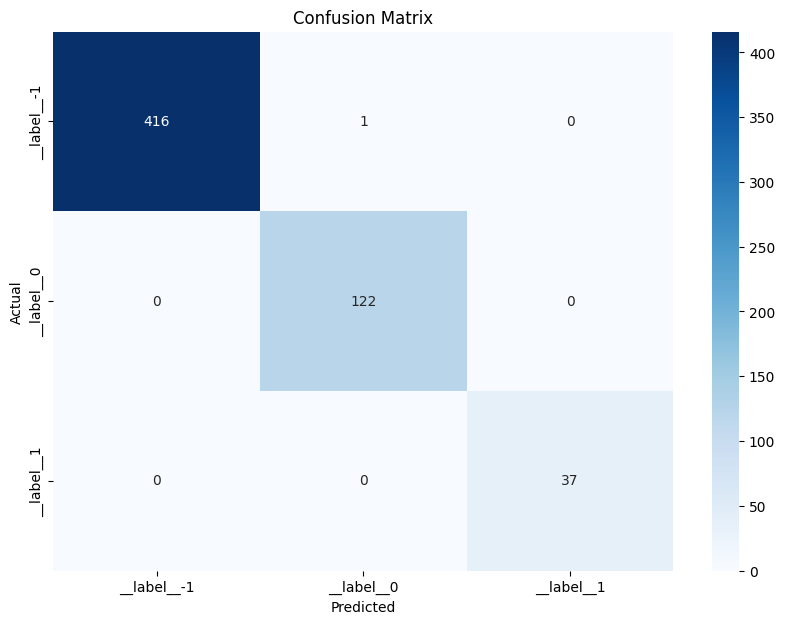

In [16]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
# Função para extrair métricas para cada classe
def calcular_metricas_por_classe(conf_matrix):
    """
    Calcula VP, FP, FN e VN para cada classe em uma matriz de confusão multiclasse.

    Parâmetros:
    conf_matrix (ndarray): Matriz de confusão.

    Retorna:
    dict: Dicionário contendo VP, FP, FN e VN para cada classe.
    """
    metricas = {}
    num_classes = conf_matrix.shape[0]

    for classe in range(num_classes):
        VP = conf_matrix[classe, classe]
        FP = conf_matrix[:, classe].sum() - VP
        FN = conf_matrix[classe, :].sum() - VP
        VN = conf_matrix.sum() - (VP + FP + FN)

        metricas[classe] = {'VP': VP, 'FP': FP, 'FN': FN, 'VN': VN}

    return metricas

# Calcula as métricas para cada classe
metricas_por_classe = calcular_metricas_por_classe(conf_matrix)

# Exibe as métricas para cada classe
for classe, metricas in metricas_por_classe.items():
    print(f"Classe {classe}:")
    print(f"  Verdadeiros Positivos (VP): {metricas['VP']}")
    print(f"  Falsos Positivos (FP): {metricas['FP']}")
    print(f"  Falsos Negativos (FN): {metricas['FN']}")
    print(f"  Verdadeiros Negativos (VN): {metricas['VN']}")

# Extrair métricas individuais para uso posterior
VP = {classe: metricas['VP'] for classe, metricas in metricas_por_classe.items()}
FP = {classe: metricas['FP'] for classe, metricas in metricas_por_classe.items()}
FN = {classe: metricas['FN'] for classe, metricas in metricas_por_classe.items()}
VN = {classe: metricas['VN'] for classe, metricas in metricas_por_classe.items()}

print("Verdadeiros Positivos (VP):", VP)
print("Falsos Positivos (FP):", FP)
print("Falsos Negativos (FN):", FN)
print("Verdadeiros Negativos (VN):", VN)

Classe 0:
  Verdadeiros Positivos (VP): 416
  Falsos Positivos (FP): 0
  Falsos Negativos (FN): 1
  Verdadeiros Negativos (VN): 159
Classe 1:
  Verdadeiros Positivos (VP): 122
  Falsos Positivos (FP): 1
  Falsos Negativos (FN): 0
  Verdadeiros Negativos (VN): 453
Classe 2:
  Verdadeiros Positivos (VP): 37
  Falsos Positivos (FP): 0
  Falsos Negativos (FN): 0
  Verdadeiros Negativos (VN): 539
Verdadeiros Positivos (VP): {0: 416, 1: 122, 2: 37}
Falsos Positivos (FP): {0: 0, 1: 1, 2: 0}
Falsos Negativos (FN): {0: 1, 1: 0, 2: 0}
Verdadeiros Negativos (VN): {0: 159, 1: 453, 2: 539}


In [30]:
# Exemplo de uso das métricas para cálculo do índice de Youden para cada classe
def calcular_indice_de_youden_por_classe(VP, FP, FN, VN):
    """
    Calcula o índice de Youden para cada classe.

    Parâmetros:
    VP, FP, FN, VN (dict): Dicionários contendo os valores para cada classe.

    Retorna:
    dict: Índice de Youden para cada classe.
    """
    indices_de_youden = {}
    for classe in VP.keys():
        sensibilidade = VP[classe] / (VP[classe] + FN[classe])
        especificidade = VN[classe] / (VN[classe] + FP[classe])
        indices_de_youden[classe] = sensibilidade + especificidade - 1

    return indices_de_youden

# Calcula o índice de Youden para cada classe
indices_de_youden = calcular_indice_de_youden_por_classe(VP, FP, FN, VN)
print("Índice de Youden por classe:", indices_de_youden)

Índice de Youden por classe: {0: 0.9976019184652278, 1: 0.9977973568281939, 2: 1.0}


#### **Results**

The FastText + SVM model exhibited promising results:

Precision: 99.826%</br>
Recall: 99.826%</br>
F1-score: 99.826%</br>
Accuracy: 99.826%</br>

**Youden Metric:**

The Youden index, also known as Youden's J statistic, is a measure used to evaluate the effectiveness of a diagnostic test. It is particularly useful in assessing the test's ability to distinguish between two conditions, such as diseased and non-diseased states. The Youden index combines sensitivity (true positive rate) and specificity (true negative rate) into a single metric.

The formula for the Youden index is:

J = sensitivity + specificity - 1

Where:

- Sensitivity (True Positive Rate) is the proportion of actual positives correctly identified by the test.
- Specificity (True Negative Rate) is the proportion of actual negatives correctly identified by the test.

The Youden index ranges from 0 to 1, where:

- 1 indicates a perfect test.
- 0 indicates a test with no diagnostic ability.

It is a useful metric for comparing the overall performance of diagnostic tests.

Detailed Analysis:</br>

The assessment of the results and the confusion matrix reveals that the model had only one misclassification error. This exceptional performance indicates the high quality of the model.

However, it is crucial to perform cross-validation to confirm the model's robustness and to rule out the possibility of overfitting. For more information about the metrics visit [12.8 FastText + SVM](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#128-fasttext-svm).



**Explanation of Overfitting:**

Overfitting occurs when an algorithm excessively or even precisely adapts to the training data, resulting in a model that cannot make accurate predictions or conclusions with data other than the training set. Such a characteristic leads to high metric results. To prevent overfitting, cross-validation is necessary, as represented below:

### Cross Validation of FastText + SVM

Cross-validation is a technique used to evaluate the performance of a machine learning model. Instead of simply splitting the dataset into a training set and a separate test set, cross-validation involves dividing the dataset into multiple subsets, or "folds". The model is trained on several combinations of these folds, and the performance metrics are averaged across these folds to provide a more robust estimate of the model's performance. This helps to ensure that the model's performance is not heavily influenced by the particular choice of training and test sets. In this code, we'll be using cross-validation to find the best parameters for our SVM classifier, which will help improve its generalization performance on unseen data.

In [ ]:
# Download necessary nltk resources
nltk.download('punkt')
nltk.download('stopwords')

Defines a function to preprocess text by converting to lowercase, removing punctuation and numbers, tokenizing, and removing stop words.

In [ ]:
def preprocess_text(text):
    """
    Text preprocessing function:
    - Converts text to lowercase
    - Removes punctuation
    - Removes numbers
    - Tokenizes the text
    - Removes stop words
    - Joins words back into a string

    Args:
    text (str): The text to preprocess

    Returns:
    str: The preprocessed text
    """
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]  # Remove stop words
    text = ' '.join(words)  # Join words back into a string
    return text


Loads the dataset, assuming it has columns named 'comment' and 'sentiment', and stores the data in lists.

In [ ]:
# Load the dataset
#dataset = pd.read_csv("classification-labeled.csv", sep=";")

# Assuming the dataset has columns 'comment' and 'sentiment'
texts = dataset['comment'].tolist()
labels = dataset['sentiment'].tolist()


Preprocesses the text data and converts labels to the format expected by FastText.



In [ ]:
# Preprocess the texts
texts = [preprocess_text(text) for text in texts]

# Convert labels to FastText format (__label__<label>)
labels = [f'__label__{label}' for label in labels]


Creates a temporary training data file in the format expected by FastText.



In [ ]:
# Create a training data file for FastText
train_data_path = 'train_data.txt'
with open(train_data_path, 'w', encoding='utf-8') as f:
    for text, label in zip(texts, labels):
        f.write(f'{label} {text}\n')


Trains a FastText model using hierarchical softmax and saves the trained model.



In [ ]:
# Train FastText model using hierarchical softmax (hs)
model = fasttext.train_supervised(input=train_data_path, lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='hs')

# Save the FastText model
model.save_model('fasttext_model_hs.bin')


Defines a function to convert text to vectors using the trained FastText model and converts all texts to vectors. Labels are converted back to integers.


In [ ]:
def text_to_vector(text):
    """
    Converts text to vector using the trained FastText model

    Args:
    text (str): The text to convert

    Returns:
    np.ndarray: The vector representation of the text
    """
    return model.get_sentence_vector(text)

# Convert texts to vectors
X = [text_to_vector(text) for text in texts]

# Convert labels back to integers
y = [int(label.replace('__label__', '')) for label in labels]


Splits the data into training and testing sets and applies SMOTE to the training set to handle class imbalance.



In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Defines the parameter grid for GridSearchCV, initializes the SVM classifier, and performs GridSearchCV to find the best parameters.



In [ ]:
# Define parameters for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # for 'poly' kernel
    'gamma': ['scale', 'auto']  # for 'rbf', 'poly', 'sigmoid' kernels
}

# Initialize SVM classifier
svm_classifier = svm.SVC()

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Perform GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Display the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)


Trains the SVM classifier with the best parameters, makes predictions on the test data, and evaluates the performance using accuracy, precision, recall, and F1-score metrics.



In [ ]:
# Train SVM with the best parameters
best_svm_classifier = grid_search.best_estimator_
best_svm_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred_test = best_svm_classifier.predict(X_test)

# Evaluate performance on test data
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_score_test = fbeta_score(y_test, y_pred_test, beta=2, average='weighted')

print("\nPerformance metrics on test data:")
print(f'Accuracy: {accuracy_test}')
print(f'Precision: {precision_test}')
print(f'Recall: {recall_test}')
print(f'F1-score: {f1_score_test}')


Defines a function to plot learning curves and plots the learning curves for the best SVM classifier. This helps to visualize the model's performance with different training sizes and cross-validation scores.




In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots learning curves for a given estimator

    Args:
    estimator: The model/estimator to evaluate
    title (str): Title of the plot
    X (np.ndarray): Feature data
    y (np.ndarray): Target labels
    ylim (tuple): Tuple defining the limits for the y-axis
    cv: Cross-validation splitting strategy
    n_jobs: Number of jobs to run in parallel
    train_sizes (np.ndarray): Array of training sizes

    Returns:
    plt: The plot
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves for the SVM
title = "Learning Curves (SVM)"
plot_learning_curve(best_svm_classifier, title, X, y, cv=5, n_jobs=-1)
plt.show()


## Transformers

### Dependencies Import

Unfortunetly, transformers require a specific version of tensorflow which is compatible with tf_hub and tf_text. This requires us to reimport and reinstall some of the dependencies

In [ ]:
!pip install --upgrade pip
!pip install protobuf==3.20
!pip install tensorflow==2.15
!pip install tensorflow_hub==0.12.0
!pip install tensorflow_text==2.8.1
##precisa clicar em cancel quando o collab tenta fazer restartar o runtime NÃO PODE RESTARTAR O COLLAB

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-aiplatform 1.48.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling proto

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.models import Sequential
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix
import seaborn as sns

### Data preprocessing:

In [ ]:
import pandas as pd
#df = pd.read_csv("src/data/classification-labeled.csv", encoding='ISO-8859-1', delimiter=';')
df = pd.read_csv('data/classification-labeled.csv', encoding='ISO-8859-1', delimiter=';')

df.sample(5)

,id,comment,sentiment
1662,1946,"""While French taxi drivers staged sometimes vi...",-1
1721,2005,"""macron corruptly helping uber accrue profit"" ...",-1
1116,1395,"Hey Uber, I took a trip on 5th July in Delhi...",-1
1870,2154,Shame on Uber! #uber #brokelaw https://t.co/...,-1
2113,2397,"Uber deliberately dodged authorities, ignored ...",-1


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Class Balancing

Here, after testing with infered data from SMOTE, the ideal solution for the class balance seem to be undersampling, one technique of undersampling that is used is joining both the 0 (neutral) and 1 (positive) labels in only one (0). Since this generates a better overall precision

In [ ]:
df['sentiment'] = df['sentiment'].replace({1: 0})

In [ ]:
df_positive = df[df['sentiment']==0 ]
df_positive.shape
df_positive['sentiment'].value_counts()

sentiment
0    866
Name: count, dtype: int64

In [ ]:
df_negative = df[df['sentiment']== -1 ]
df_negative.shape

(2010, 3)

In [ ]:
df_negative['sentiment'].value_counts()

sentiment
-1    2010
Name: count, dtype: int64

Undersampling the 2010 negative comments to 866 comments. Then the classes will have the same number of data.

In [ ]:
df_positive = df[df['sentiment'] == 0]
df_negative = df[df['sentiment'] == -1]

df_negative_downsample = df_negative.sample(n=df_positive.shape[0], random_state=42)

df_balanced = pd.concat([df_negative_downsample, df_positive])

print(df_balanced.shape)
print(df_balanced['sentiment'].value_counts())


(1732, 3)
sentiment
-1    866
 0    866
Name: count, dtype: int64


In [ ]:
df = df_balanced

Encoding the classes for -1 (negative) to be 0 and 0 (positives and neutrals) to 1

In [ ]:
df['sentiment'] = df['sentiment'].map({-1: 0, 0: 1})

Basic preprocessing, filtering and tokenizing:

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

df['comment'] = df['comment'].apply(remove_stopwords)

df.sample(5)

,id,comment,sentiment
377,647,"Uber , railroad conductors .",1
1361,1641,? feel like Uber today lol,1
1742,2026,"Uber broke laws , duped police built secret lo...",0
403,673,. employers simply pay workers instead relying...,1
372,627,"$ UBER Uber broke laws , duped police secretly...",0


In [ ]:
df['sentiment'].unique()

array([0, 1])

Splitting the dataframe in train and test:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["comment"], df["sentiment"], test_size=0.3, random_state=42)

### Inicialization of BERT

BERT (Bidirectional Encoder Representations from Transformers) is a natural language processing model based on the Transformer architecture. It is trained to understand the context of words in texts through a method called masked language modeling, where some words are hidden and the model tries to predict them. Additionally, it also learns the relationship between sentence pairs. BERT's ability to analyze texts bidirectionally, considering the full context of each word, makes it efficient for a variety of NLP tasks, such as sentiment analysis!

It is also important to list and understand how BERT works:

1. Input Representation:
- Tokenization: BERT starts by tokenizing the text into tokens that can be found in its vocabulary. It uses WordPiece tokenization, splitting words into subwords or tokens. For example, "smiling" might be split into "smile" and "##ing".
- Special Tokens: It adds special tokens like [CLS] at the beginning of the text and [SEP] to separate segments or denote the end of a sentence.
Segment Embeddings: If there are two sentences (like in question-answering tasks), BERT can differentiate them using segment embeddings A and B.
- Positional Embeddings: Since the Transformer architecture does not inherently capture sequence order, BERT adds positional embeddings to give the model information about the position of tokens in the sequence.

2. Processing by Transformer Blocks:
- Layers: BERT processes the input sequence through multiple layers (12 for BERT-base, 24 for BERT-large) of Transformer blocks.
- Self-Attention: Each Transformer block uses self-attention mechanisms that allow the model to weigh the importance of all tokens in the input sequence, regardless of their position. This means each token is influenced by all other tokens.
- Bidirectionality: This self-attention mechanism is what allows BERT to be bidirectional, meaning it learns information from both the left and right context of a token simultaneously.
- Feed-Forward Neural Networks: Each layer also contains feed-forward neural networks that transform the representation at each position of the sequence.

3. Output
- Contextualized Embeddings: The output from the final Transformer layer is a set of contextualized word embeddings. Unlike traditional embeddings, these represent not just the word, but also the context in which it appears.
- Task-Specific Layers: For specific tasks, these embeddings are passed through additional layers. For instance, for classification tasks, the output corresponding to the [CLS] token is typically used to make predictions. For question answering, the model predicts the start and end positions of the answer in the context.

4. Pre-training and Fine-tuning
- Pre-training: Before being used for specific tasks, BERT is pre-trained on a large corpus of text. It learns by predicting 15% of the words in each sequence, which have been randomly masked (Masked Language Model), and by predicting whether a second sentence in a pair is the subsequent sentence in the original text (Next Sentence Prediction).
- Fine-tuning: After pre-training, BERT can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks like classification, entity recognition, and question answering, with relatively minimal task-specific data.

For more information about the model visit documentation  [session 9.6 Transformers - BERT](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#96-transformers-bert).


Here the preprocessor and encoder are imported and started from BERT

In [ ]:
url_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

url_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2"

bert_preprocess = hub.KerasLayer(url_preprocess)
bert_encoder = hub.KerasLayer(url_encoder, trainable=True)

In [ ]:
text_input = Input(shape=(), dtype=tf.string,name='Comment')
Preprocessor = bert_preprocess(text_input)
output = bert_encoder(Preprocessor)

The layers of the neural network are defined, such as the activation functions, the dropout rates and sets the model as trainable, which means that it can shift the weight of different atributes at it is beeing used


In [ ]:
x = Dense(256, activation='relu', name="Dense_256")(output["pooled_output"])
x = Dropout(0.5, name="dropout_1")(x)
x = Dense(64, activation='relu', name="Dense_64")(x)
x = Dropout(0.5, name="dropout_2")(x)
outputs = Dense(1, activation='sigmoid', name="output")(x)

model = Model(inputs=[text_input], outputs=outputs)

model.trainable = True

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Comment (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['Comment[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss="binary_crossentropy",
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
38/38 [==============================] - 129s 3s/step - loss: 0.7000 - accuracy: 0.5429 - val_loss: 0.5959 - val_accuracy: 0.7000
Epoch 2/10
38/38 [==============================] - 99s 3s/step - loss: 0.6051 - accuracy: 0.6947 - val_loss: 0.5010 - val_accuracy: 0.7673
Epoch 3/10
38/38 [==============================] - 100s 3s/step - loss: 0.5387 - accuracy: 0.7384 - val_loss: 0.4649 - val_accuracy: 0.7885
Epoch 4/10
38/38 [==============================] - 98s 3s/step - loss: 0.4755 - accuracy: 0.7904 - val_loss: 0.4811 - val_accuracy: 0.7750
Epoch 5/10
38/38 [==============================] - 99s 3s/step - loss: 0.4496

The confusion matrix is plotted so we can check the model:

In [ ]:
y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

conf_mat = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

For more information about the metrics visit [12.4 Transformers](https://github.com/Inteli-College/2024-1B-T10-SI06-G01/blob/main/documentos/documentation.md#124-transformers).
